In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load datasets
trades_data = pd.read_csv('/content/trades_EQUITIES (2).csv')
xnas_data = pd.read_csv('/content/xnas-itch-20230703.tbbo.csv')


In [3]:
# Convert to numeric and drop NaNs
trades_data['Trade Price'] = pd.to_numeric(trades_data['Trade Price'], errors='coerce')
trades_data['Trade Size'] = pd.to_numeric(trades_data['Trade Size'], errors='coerce')
xnas_data['price'] = pd.to_numeric(xnas_data['price'], errors='coerce')
xnas_data['size'] = pd.to_numeric(xnas_data['size'], errors='coerce')
xnas_data['bid_px_00'] = pd.to_numeric(xnas_data['bid_px_00'], errors='coerce')
xnas_data['ask_px_00'] = pd.to_numeric(xnas_data['ask_px_00'], errors='coerce')

trades_data = trades_data.dropna(subset=['Trade Price', 'Trade Size'])
xnas_data = xnas_data.dropna(subset=['price', 'size', 'bid_px_00', 'ask_px_00'])

In [4]:
# Scale prices
xnas_data['price'] /= 1e9
xnas_data['bid_px_00'] /= 1e9
xnas_data['ask_px_00'] /= 1e9

In [5]:
# Prepare columns for indicators
xnas_data['Close'] = xnas_data['price']
xnas_data['Volume'] = xnas_data['size']
xnas_data['High'] = xnas_data[['bid_px_00', 'ask_px_00']].max(axis=1)
xnas_data['Low'] = xnas_data[['bid_px_00', 'ask_px_00']].min(axis=1)
xnas_data['Open'] = xnas_data['Close'].shift(1).fillna(xnas_data['Close'])

In [6]:
# Define indicator functions
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, slow=26, fast=12, signal=9):
    fast_ema = data.ewm(span=fast, min_periods=fast).mean()
    slow_ema = data.ewm(span=slow, min_periods=slow).mean()
    macd = fast_ema - slow_ema
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    macd_hist = macd - signal_line
    return macd, signal_line, macd_hist

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, rolling_mean, lower_band

In [7]:
# Calculate indicators
xnas_data['RSI'] = calculate_rsi(xnas_data['Close'])
xnas_data['MACD'], xnas_data['MACD_signal'], xnas_data['MACD_hist'] = calculate_macd(xnas_data['Close'])
xnas_data['Upper_BB'], xnas_data['Middle_BB'], xnas_data['Lower_BB'] = calculate_bollinger_bands(xnas_data['Close'])

xnas_data = xnas_data.dropna()

In [8]:
# Select features and target
features = ['RSI', 'MACD', 'MACD_signal', 'Upper_BB', 'Middle_BB', 'Lower_BB']
target = 'Close'

In [9]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(xnas_data[features])
scaled_target = scaler.fit_transform(xnas_data[[target]])

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_target, test_size=0.2, shuffle=False)

In [11]:
class MarketDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.target[idx], dtype=torch.float32)

# Create DataLoader
train_dataset = MarketDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MarketDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
# Transformer model definition
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        src = src.unsqueeze(1)
        transformer_output = self.transformer_encoder(src)
        output = self.fc(transformer_output.squeeze(1))
        return output


In [13]:
# Model parameters
input_dim = len(features)
output_dim = 1
model = TransformerModel(input_dim=input_dim, num_heads=4, num_layers=2, output_dim=output_dim)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    best_loss = float('inf')
    early_stop_count = 0
    patience = 5
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size()[0])

        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            scheduler.step(val_loss)

        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_count += 1

        if early_stop_count >= patience:
            print('Early stopping')
            break

In [16]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to (batch_size, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [17]:
# Train the model
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 0.0049, Val Loss: 0.0054
Epoch 2, Loss: 0.0032, Val Loss: 0.0066
Epoch 3, Loss: 0.0022, Val Loss: 0.0066
Epoch 4, Loss: 0.0017, Val Loss: 0.0062
Epoch 5, Loss: 0.0022, Val Loss: 0.0039
Epoch 6, Loss: 0.0022, Val Loss: 0.0040
Epoch 7, Loss: 0.0016, Val Loss: 0.0041
Epoch 8, Loss: 0.0069, Val Loss: 0.0029
Epoch 9, Loss: 0.0030, Val Loss: 0.0025
Epoch 10, Loss: 0.0030, Val Loss: 0.0027
Epoch 11, Loss: 0.0011, Val Loss: 0.0024
Epoch 12, Loss: 0.0008, Val Loss: 0.0031
Epoch 13, Loss: 0.0027, Val Loss: 0.0024
Epoch 14, Loss: 0.0025, Val Loss: 0.0022
Epoch 15, Loss: 0.0005, Val Loss: 0.0021
Epoch 16, Loss: 0.0012, Val Loss: 0.0016
Epoch 17, Loss: 0.0004, Val Loss: 0.0019
Epoch 18, Loss: 0.0010, Val Loss: 0.0014
Epoch 19, Loss: 0.0003, Val Loss: 0.0013
Epoch 20, Loss: 0.0012, Val Loss: 0.0013
Epoch 21, Loss: 0.0004, Val Loss: 0.0013
Epoch 22, Loss: 0.0005, Val Loss: 0.0014
Epoch 23, Loss: 0.0007, Val Loss: 0.0010
Epoch 24, Loss: 0.0016, Val Loss: 0.0009
Epoch 25, Loss: 0.0008, V

In [18]:
# Predict on the test set
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

In [19]:
# Rescale predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [20]:
# Create a DataFrame with predictions and actual values
evaluation_df = pd.DataFrame({
    'Actual': y_test_rescaled.flatten(),
    'Predicted': predictions_rescaled.flatten()
})

print(evaluation_df.head())

   Actual   Predicted
0  192.28  192.305618
1  192.28  192.307419
2  192.28  192.309113
3  192.28  192.310425
4  192.27  192.314301


In [21]:
# Evaluate the model's performance
mse = ((evaluation_df['Actual'] - evaluation_df['Predicted']) ** 2).mean()
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 0.0090


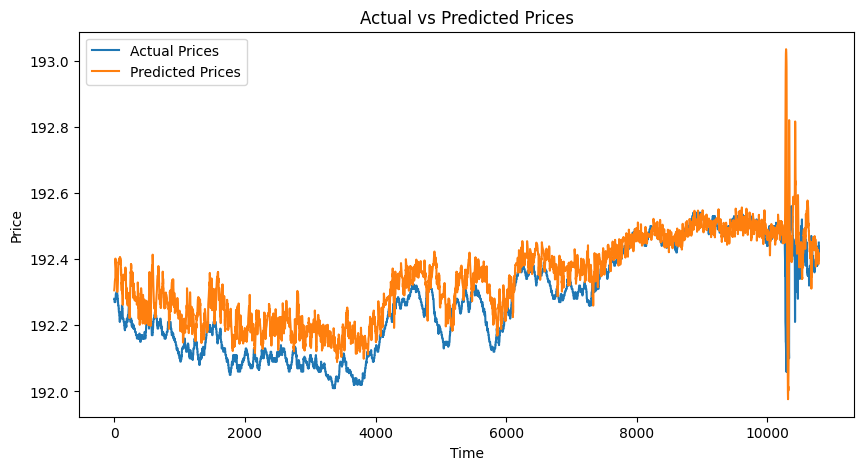

In [22]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(evaluation_df['Actual'], label='Actual Prices')
plt.plot(evaluation_df['Predicted'], label='Predicted Prices')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.show()

In [23]:
# Calculate the differences
evaluation_df['Difference'] = evaluation_df['Predicted'] - evaluation_df['Actual']

# Summary statistics
print(evaluation_df['Difference'].describe())

count    10788.000000
mean         0.062803
std          0.071143
min         -0.500147
25%          0.017120
50%          0.060849
75%          0.104720
max          0.965986
Name: Difference, dtype: float64


In [24]:
# Create a new feature for the difference between predicted and actual prices
evaluation_df['Predicted_Diff'] = evaluation_df['Predicted'] - evaluation_df['Actual']

# Verify the column was created
print(evaluation_df[['Actual', 'Predicted', 'Predicted_Diff']])

       Actual   Predicted  Predicted_Diff
0      192.28  192.305618        0.025618
1      192.28  192.307419        0.027419
2      192.28  192.309113        0.029113
3      192.28  192.310425        0.030425
4      192.27  192.314301        0.044301
...       ...         ...             ...
10783  192.44  192.414261       -0.025739
10784  192.44  192.419281       -0.020719
10785  192.40  192.396332       -0.003668
10786  192.45  192.411011       -0.038989
10787  192.45  192.406219       -0.043781

[10788 rows x 3 columns]


In [25]:
threshold = 0.09  # Adjust threshold based on performance

# Re-generate signals
evaluation_df['Signal'] = np.where(
    evaluation_df['Predicted_Diff'] > threshold, 1,  # Buy signal
    np.where(
        evaluation_df['Predicted_Diff'] < -threshold, -1,  # Sell signal
        0  # Hold signal
    )
)

# Display new signal distribution
print(evaluation_df['Signal'].value_counts())

Signal
 0    7214
 1    3510
-1      64
Name: count, dtype: int64


In [26]:
# Trading blotter function
def trading_blotter(evaluation_df, initial_balance=100000, transaction_cost=0.001):
    balance = initial_balance
    shares_held = 0
    trades = []
    strategy_returns = []

    for i in range(len(evaluation_df)):
        actual_price = evaluation_df['Actual'].iloc[i]
        signal = evaluation_df['Signal'].iloc[i]

        if signal == 1 and balance > actual_price:
            shares_to_buy = balance // actual_price
            balance -= shares_to_buy * actual_price * (1 + transaction_cost)
            shares_held += shares_to_buy
            trades.append({'action': 'buy', 'price': actual_price, 'shares': shares_to_buy, 'balance': balance})
        elif signal == -1 and shares_held > 0:
            balance += shares_held * actual_price * (1 - transaction_cost)
            strategy_return = (actual_price - trades[-1]['price']) / trades[-1]['price']
            strategy_returns.append(strategy_return)
            trades.append({'action': 'sell', 'price': actual_price, 'shares': shares_held, 'balance': balance})
            shares_held = 0

    # Calculate final balance
    final_balance = balance + shares_held * evaluation_df['Actual'].iloc[-1]
    return final_balance, trades, strategy_returns

In [27]:
# Run the trading blotter
final_balance, trades, strategy_returns = trading_blotter(evaluation_df)
print(f"Final balance after trading: ${final_balance:.2f}")

Final balance after trading: $99486.06


In [28]:
# Convert trades to a DataFrame for further analysis
trades_df = pd.DataFrame(trades)
print(trades_df)

  action   price  shares      balance
0    buy  192.28   520.0    -85.58560
1   sell  192.49   520.0  99909.11960
2    buy  192.16   519.0     78.34856
3   sell  192.49   519.0  99880.75625
4    buy  192.46   518.0     86.78197
5   sell  192.50   518.0  99702.06697
6    buy  192.38   518.0    -50.42587
7   sell  192.45   518.0  99538.98503
8    buy  192.36   517.0    -10.58509


In [29]:

# Calculate performance metrics
def calculate_metrics(evaluation_df, strategy_returns, initial_balance):
    # Calculate cumulative returns for the strategy
    strategy_cumulative_returns = np.cumsum(strategy_returns)

    # Calculate cumulative returns for the market
    evaluation_df['Daily Return'] = evaluation_df['Actual'].pct_change()
    evaluation_df['Cumulative Return'] = (1 + evaluation_df['Daily Return']).cumprod() - 1

    # Plot cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(evaluation_df['Cumulative Return'], label='Cumulative Market Returns')
    plt.plot(strategy_cumulative_returns, label='Cumulative Strategy Returns')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.title('Market vs Strategy Cumulative Returns')
    plt.show()
# Calculate Sharpe ratio
    if len(strategy_returns) > 0:
        mean_return = np.mean(strategy_returns)
        std_dev_return = np.std(strategy_returns)
        sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252)  # Annualized Sharpe ratio
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        if sharpe_ratio > 3:
            print("Excellent performance")
        elif 2 < sharpe_ratio <= 3:
            print("Good performance")
        elif 1 < sharpe_ratio <= 2:
            print("Acceptable performance")
        else:
            print("Suboptimal performance")
    else:
        print("No strategy returns to calculate Sharpe ratio.")


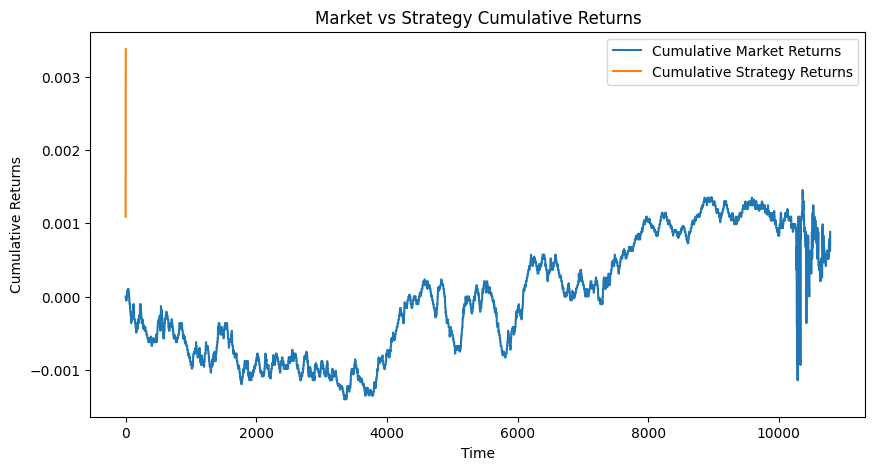

Sharpe Ratio: 22.21
Excellent performance


In [30]:
# Recalculate and display metrics
calculate_metrics(evaluation_df, strategy_returns, initial_balance=100000)